## Resample rebooted: working with projections -- output to h5

In resample.ipynb we output the image in geotiff format using the gdal library.  This is fine
for working with gis software, but the data format is limited compared to the flexibility
of hdf5.  This notebook adds hdf5 output to the geotiff image created by gdal.

1) pick a map projection

2) define an x,y in grid in meters based on that projection

3) resample the satellite data onto that grid

4) save it as a h5 file, which maintains all the information about the projection we used

5) save it as geotiff file, which can be read by gis software



## First, get channel 1 and the lat/lon files as usual

In [1]:
import h5py
import numpy as np
import pyproj
import pyresample
from pyresample import kd_tree,geometry
from matplotlib import pyplot as plt
from e582utils.modismeta_read import parseMeta
from e582utils.data_read import download
from mpl_toolkits.basemap import Basemap

data_name='MYD021KM.A2016224.2100.006.2016225153002.h5'
download(data_name)
geom='MYD03.A2016224.2100.006.2016225152335.h5'
download(geom)

index=0
my_name = 'EV_250_Aggr1km_RefSB'
with h5py.File(data_name,'r') as h5_file:
    chan1=h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][my_name][index,:,:]
    scale=h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][my_name].attrs['reflectance_scales'][...]
    offset=h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][my_name].attrs['reflectance_offsets'][...]
chan1_calibrated =(chan1 - offset[index])*scale[index]
    
with h5py.File(geom) as geo_file:
    lon_data=geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields']['Longitude'][...]
    lat_data=geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields']['Latitude'][...]


MYD021KM.A2016224.2100.006.2016225153002.h5 already exists, need to either delete or rename for new download
MYD03.A2016224.2100.006.2016225152335.h5 already exists, need to either delete or rename for new download


### Next use a new function to get the corner points and the center lat and lon from MODIS metadata

The function is [parseMeta](https://github.com/a301-teaching/a301_code/blob/b3ea180566d2fd3acd5ea3a246d6c0eb6ae14a41/a301utils/modismeta_read.py#L106) and you
can treat it as a black box unless you're interested in how regular expressions work in python. It does
the same thing that [find_corners](https://github.com/a301-teaching/a301_code/blob/b3ea180566d2fd3acd5ea3a246d6c0eb6ae14a41/a301lib/geolocate.py#L16) does, but
skips the calculation, since NASA has already computed everything we need more accurately.

In [2]:
corners=parseMeta(data_name)
proj_id = 'laea'
datum = 'WGS84'
lat_0_txt = '{lat_0:5.2f}'.format_map(corners)
lon_0_txt= '{lon_0:5.2f}'.format_map(corners)

1. In order to get the correct bounding box, we need to take the 4 corner lon,lat values and
   and transform them to x,y values for this projection

2. Once we've done that, we can get the minimum x and y, which become the projected coordinates
   of the lower left corner of the viewing box, and the maximum x and y, which become the projected coordinates of the
   upper right corner of the viewing box.

3. Finally, we inverse transform the corners back to lon,lat


In [3]:
#
# arguments needed by pyproj
#
area_dict = dict(datum=datum,lat_0=lat_0_txt,lon_0=lon_0_txt,
                proj=proj_id,units='m')
#
# create the projection
#
prj=pyproj.Proj(area_dict)
#
# use it to project the granule corners
#
x, y = prj(corners['lon_list'], corners['lat_list'])
#
# find the corners in map space
#
minx,maxx=np.min(x),np.max(x)
miny,maxy=np.min(y),np.max(y)
#
# back transform these to lon/lat
#
llcrnrlon,llcrnrlat=prj(minx,miny,inverse=True)
urcrnrlon,urcrnrlat=prj(maxx,maxy,inverse=True)

In [4]:
#
# 1300 m pixels are a reasonable compromise between the smallest 1km pixels and the biggest
# 4 km pixels at the sides of the swath
#
area_extent=[minx,miny,maxx,maxy]
x_pixel=1.3e3
y_pixel=1.3e3
xsize=int((area_extent[2] - area_extent[0])/x_pixel)
ysize=int((area_extent[3] - area_extent[1])/y_pixel)
#
#  here's the dictionary we need for basemap
#
a, b = pyresample.plot.ellps2axis('wgs84')
rsphere = (a, b)
basemap_args=dict()
basemap_args['rsphere'] = rsphere
basemap_args['llcrnrlon'] = llcrnrlon
basemap_args['llcrnrlat'] = llcrnrlat
basemap_args['urcrnrlon'] = urcrnrlon
basemap_args['urcrnrlat'] = urcrnrlat
basemap_args['projection'] = area_dict['proj']
basemap_args['lat_0']=corners['lat_0']
basemap_args['lon_0']=corners['lon_0']
print('image will be {} columns x {} rows'.format(xsize,ysize))

image will be 2222 columns x 1943 rows


## 1.  Pick a map projection

The program that resamples modis data onto a particular projected grid is
[pyresample](http://pyresample.readthedocs.io/en/latest/index.html).   I'll resample the swath
using a [lambert azimuthal equal area](http://matplotlib.org/basemap/users/laea.html) projection with square pixels
approximately 1.3 km x 1.3 km

The output will be a 2222 x 1943 array called result which has the channel 1 data resampled onto
a grid centered at the lat_0,lon_0 center of the swath.  The values will be determined by averaging the nearest
neighbors to a particular cell location, using a zone of influence with a radius of 5000 meters, and
a [kd-tree](https://en.wikipedia.org/wiki/K-d_tree)

The next cell puts the projection into a structure that pyresample understands, and does the resampling

### 2. and 3.: define an x,y grid and resample onto it

In [5]:
fill_value=-9999.
area_id = 'granule'
area_name = 'modis swath 5min granule'
#
# here are all the arguments pyresample needs to regrid the swath
#
area_def_args=dict(area_id=area_id,area_name=area_name,proj_id=proj_id,
                  area_dict=area_dict,xsize=xsize,ysize=ysize,area_extent=area_extent)
area_def = geometry.AreaDefinition(area_id, area_name, proj_id, 
                                   area_dict, xsize,ysize, area_extent)
swath_def = geometry.SwathDefinition(lons=lon_data, lats=lat_data)
result = kd_tree.resample_nearest(swath_def, chan1_calibrated.ravel(),
                                  area_def, radius_of_influence=5000, nprocs=2,fill_value=fill_value)
print('\ndump area definition:\n{}\n'.format(area_def))
print('\nx and y pixel dimensions in meters:\n{}\n{}\n'.format(area_def.pixel_size_x,area_def.pixel_size_y))
nan_value = np.array([np.nan],dtype=np.float32)[0]
result[result<0]=nan_value


dump area definition:
Area ID: granule
Name: modis swath 5min granule
Projection ID: laea
Projection: {'datum': 'WGS84', 'lat_0': '46.13', 'lon_0': '-122.60', 'proj': 'laea', 'units': 'm'}
Number of columns: 2222
Number of rows: 1943
Area extent: (-1280423.9837223431, -1189924.0707889115, 1609332.4889824667, 1336446.4037335052)


x and y pixel dimensions in meters:
1300.5204647636408
1300.2421381999056



### plot the reprojected image

here are the basemap keywords:  {'ax': <matplotlib.axes._subplots.AxesSubplot object at 0x10c561518>, 'llcrnrlon': -136.53911711598428, 'urcrnrlat': 55.64793157078861, 'rsphere': (6378137.0, 6356752.314245179), 'lon_0': -122.60317657850351, 'urcrnrlon': -96.49588633620655, 'llcrnrlat': 34.43216712325068, 'resolution': 'c', 'lat_0': 46.12922265815655, 'projection': 'laea'}


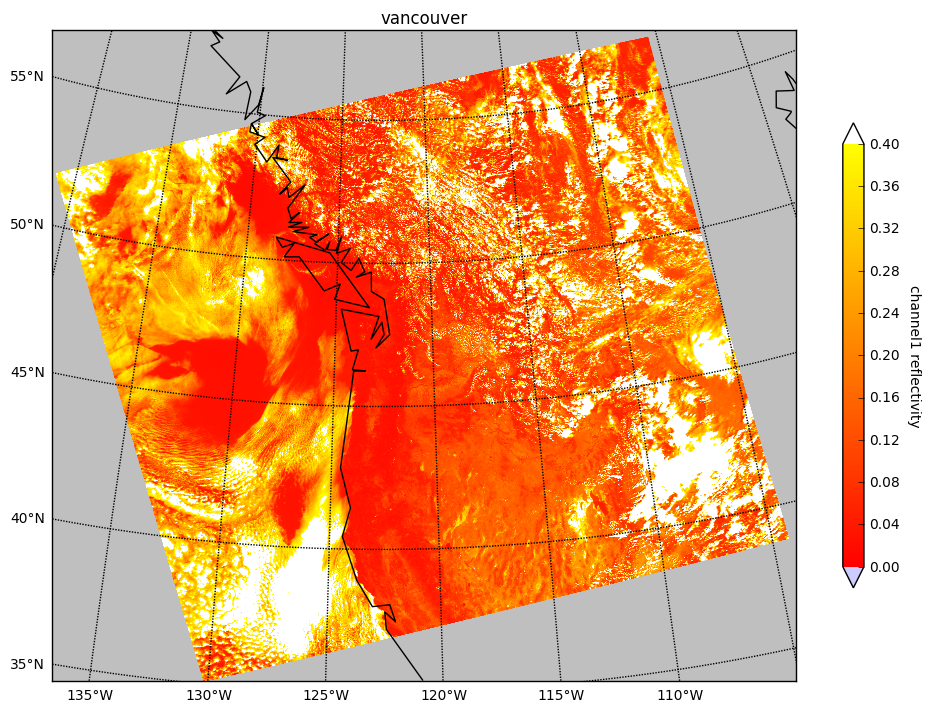

In [6]:
%matplotlib inline
from matplotlib import cm
from matplotlib.colors import Normalize

cmap=cm.autumn  #see http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps
cmap.set_over('w')
cmap.set_under('b',alpha=0.2)
cmap.set_bad('0.75') #75% grey

plt.close('all')
fig,ax = plt.subplots(1,1, figsize=(12,12))
#
# add the resolutiona and axis in separately, so we can
# change in other plots
#
basemap_kws=dict(resolution='c',ax=ax)
basemap_kws.update(basemap_args)
bmap=Basemap(**basemap_kws)
print('here are the basemap keywords: ',basemap_kws)
num_meridians=180
num_parallels = 90
vmin=None; vmax=None
col = bmap.imshow(result, origin='upper',cmap=cmap, vmin=0, vmax=0.4)
lon_sep, lat_sep = 5,5
parallels = np.arange(-90, 90, lat_sep)
meridians = np.arange(0, 360, lon_sep)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],
                       fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],
                       fontsize=10, latmax=90)
bmap.drawcoastlines()
colorbar=fig.colorbar(col, shrink=0.5, pad=0.05,extend='both')
colorbar.set_label('channel1 reflectivity',rotation=-90,verticalalignment='bottom')
_=ax.set(title='vancouver')

### 4. Write this out as a h5 file

Here's how to create a h5 file that saves all of the projection infomation along with
the gridded raster image of channel 1.   We want to be able to open this h5 file and
create a geotiff automatically, so we need a way to put in all of the information that
gdal needs for geotiff writing.   That includes the projection string used by pyproj/proj4 and
the [transformation matrix](http://en.wikipedia.org/wiki/Transformation_matrix] to go from
[row, column]  (which gdal calls [Xpixel,Yline]) to Xgeo, Ygeo -- the x,y in meters in the
projection coordinate system.   This matrix is called the adfGeoTransform (where I'm guessing that
adf stands for ["Arcinfo data format"](http://www.gdal.org/frmt_various.html#AIG)) and the 6 individual
components look like this (see http://www.gdal.org/gdal_tutorial.html):

    adfGeoTransform[0]/* top left x */
    adfGeoTransform[1]/* w-e pixel resolution */
    adfGeoTransform[2]/* rotation, 0 if image is "north up" */ otherwise 
    adfGeoTransform[3]/* top left y */
    adfGeoTransform[4]/* rotation, 0 if image is "north up" */
    adfGeoTransform[5]/* n-s pixel resolution */

To go from [Xpixel,Yline] to Xgeo,Ygeo, see http://www.gdal.org/gdal_datamodel.html:

    GT = adfGeoTransform
    Xgeo = GT[0] + Xpixel*GT[1] 
    Ygeo = GT[3] + Yline*GT[5] 

This assumes no rotation (which will always be true for this course).  If there is rotation, things get more complicated, see 
http://lists.osgeo.org/pipermail/gdal-dev/2011-July/029449.html

Other references:

   * http://en.wikipedia.org/wiki/Geographical_distance#Spherical_Earth_projected_to_a_plane
   * http://en.wikipedia.org/wiki/Transformation_matrix#Rotation for more detail




In [7]:
#
# translate the pyresample areadef extent and pixel size info into a
# gdal transfom
#


adfgeotransform = [area_def.area_extent[0], area_def.pixel_size_x, 0,
                   area_def.area_extent[3], 0, -area_def.pixel_size_y]
proj4_string=area_def.proj4_string
proj_id = area_def.proj_id
height,width=result.shape

#
# these are all the arguments gdal needs to write a geotiff
#
geotiff_args = args=dict(width=width,height=height,adfgeotransform=adfgeotransform,
         proj4_string=proj4_string,proj_id=proj_id)

Now I need to store this complicated nested dictionary into an h5 file that doesn't know about
dictionaries.  Since the dictionary is small, the easiest way to do this is to store it as a
a string using [Javascript Object Notation](https://en.wikipedia.org/wiki/JSON).  I'll write the string
into the h5 file as a global attribute called *geotiff_args*.  Python handles this using the built-in
[json module](https://docs.python.org/3/library/json.html)


In [8]:
#
# store this nested dictionary 
#

import pprint
pp = pprint.PrettyPrinter(indent=4)
import json
# 
#
#
geotiff_string = json.dumps(geotiff_args,indent=4)
print('\nhere is the JSON string:\n{}\n '.format(geotiff_string))

output='saveit.h5'
with h5py.File(output,'w') as f:
    group=f.create_group('channels')
    dset=group.create_dataset('chan1',result.shape,dtype=result.dtype)
    dset[...]=result[...]
    f.attrs['geotiff_args']=geotiff_string
    


here is the JSON string:
{
    "proj4_string": "+proj=laea +units=m +lat_0=46.13 +lon_0=-122.60 +datum=WGS84",
    "height": 1943,
    "proj_id": "laea",
    "width": 2222,
    "adfgeotransform": [
        -1280423.983722343,
        1300.5204647636408,
        0,
        1336446.4037335052,
        0,
        -1300.2421381999056
    ]
}
 


In [9]:
with h5py.File(output,'r') as f:
    geotiff_string=f.attrs['geotiff_args']
    geotiff_args = json.loads(geotiff_string)
pp.pprint(geotiff_args)

{   'adfgeotransform': [   -1280423.983722343,
                           1300.5204647636408,
                           0,
                           1336446.4037335052,
                           0,
                           -1300.2421381999056],
    'height': 1943,
    'proj4_string': '+proj=laea +units=m +lat_0=46.13 +lon_0=-122.60 '
                    '+datum=WGS84',
    'proj_id': 'laea',
    'width': 2222}


### 5. Add addtional information

While we're at it, we might as well save the information used by pyresample and basemap in the same file

In [10]:
basemap_string = json.dumps(basemap_args,indent=4)
area_def_string = json.dumps(area_def_args,indent=4)
#
# appended (use 'a' so you don't delete current data)
#
with h5py.File(output,'a') as f:
    f.attrs['basemap_args']=basemap_string
    f.attrs['area_def_args']=area_def_string
    f.attrs['fill_value']=nan_value

### 6. Check the file structure

In [11]:
from e582utils import h5dump
h5dump.dumph5(output)

++++++++++++++++++++
found the following top-level items: 
channels: <HDF5 group "/channels" (1 members)>
++++++++++++++++++++
_______________
root group object <HDF5 group "/channels" (1 members)>
_______________
member of group:  /channels <HDF5 dataset "chan1": shape (1943, 2222), type "<f4">
-------------------
attributes for the root file
-------------------
attribute name:  geotiff_args --- value:  {
    "proj4_string": "+proj=laea +units=m +lat_0=46.13 +lon_0=-122.60 +datum=WGS84",
    "height": 1943,
    "proj_id": "laea",
    "width": 2222,
    "adfgeotransform": [
        -1280423.983722343,
        1300.5204647636408,
        0,
        1336446.4037335052,
        0,
        -1300.2421381999056
    ]
}
attribute name:  basemap_args --- value:  {
    "rsphere": [
        6378137.0,
        6356752.314245179
    ],
    "llcrnrlon": -136.53911711598428,
    "urcrnrlat": 55.64793157078861,
    "llcrnrlat": 34.43216712325068,
    "lat_0": 46.12922265815655,
    "lon_0": -122.6031

In [12]:
adfgeotransform

[-1280423.9837223431,
 1300.5204647636408,
 0,
 1336446.4037335052,
 0,
 -1300.2421381999056]

In [13]:
proj4_string=area_def.proj4_string

In [14]:
result.shape
result.dtype

dtype('float32')

In [15]:
from osgeo import gdal, osr

In [18]:
filename='test2.tif'
height,width=result.shape
raster = gdal.GetDriverByName("GTiff")
gformat = gdal.GDT_Float32
dst_ds = raster.Create(filename,width,height,
                       1,gformat,)
dst_ds.SetGeoTransform(adfgeotransform)
srs = osr.SpatialReference()
srs.ImportFromProj4(proj4_string)
proj_id='laea'
srs.SetProjCS(proj_id)
srs = srs.ExportToWkt()
dst_ds.SetProjection(srs)
dst_ds.GetRasterBand(1)
dst_ds.RasterYSize
del dst_ds

In [19]:
!gdalinfo test2.tif

Driver: GTiff/GeoTIFF
Files: test2.tif
Size is 2222, 1943
Coordinate System is:
PROJCS["laea",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",46.13],
    PARAMETER["longitude_of_center",-122.6],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]
Origin = (-1280423.983722343109548,1336446.403733505168930)
Pixel Size = (1300.520464763640803,-1300.242138199905639)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-1280423.984, 1336446.404) (143d39'59.07"W, 56d33' 8.04"N)
Lower Left  (-1280423.984,-1189924.071) (136d32'20.82"W, 34d25'55.80"